In [2]:
import numpy as np
import seaborn as sns
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
import pandas as pd

# M1: RPPA protein data.
Measured from primary tumours from TCGA HNSC participants. Prediction on the PFI cancer-related outcome.

### prior analysis

In [58]:
c_df = pd.read_csv("/content/sample_data/clinical.txt", sep="\t")
c_df.set_index("participant", inplace=True)
c_df

,female,histology,age.at.diagnosis,ethnicity,race,positive.lymphnodes,stage,tnm.m.category,tnm.n.category,tnm.t.category,...,monocyte.infiltration,neutrophil.infiltration,necrosis.percent,normal.cells.percent,stromal.cells.percent,tumor.cells.percent,pfi,pfi.time,dfi,dfi.time
participant,,,,,,,,,,,,,,,,,,,,,
5557,True,head & neck squamous cell carcinoma,41,hispanic or latino,NaN,1.0,stage iii,NaN,n1,t1,...,NaN,NaN,2,0.0,50.0,48,0,623,NaN,NaN
5559,False,head & neck squamous cell carcinoma,71,not hispanic or latino,white,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0.0,15.0,85,1,1614,NaN,NaN
6871,False,head & neck squamous cell carcinoma,75,NaN,white,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,0.0,19.0,80,1,108,NaN,NaN
4727,False,head & neck squamous cell carcinoma,56,not hispanic or latino,white,0.0,stage iva,NaN,n0,t4,...,NaN,NaN,0,0.0,20.0,80,0,1560,NaN,NaN
6021,True,head & neck squamous cell carcinoma,63,not hispanic or latino,white,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0.0,15.0,85,1,276,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,True,head & neck squamous cell carcinoma,55,not hispanic or latino,white,NaN,stage i,NaN,n0,t1,...,NaN,NaN,1,0.0,30.0,69,0,568,0.0,568.0
7591,False,head & neck squamous cell carcinoma,62,not hispanic or latino,white,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0.0,15.0,85,0,622,NaN,NaN
7592,False,head & neck squamous cell carcinoma,57,not hispanic or latino,american indian or alaska native,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0.0,15.0,85,0,1143,NaN,NaN


In [17]:
# sns.heatmap(c_df.corr(), cmap="Blues")

In [59]:
p_df = pd.read_csv("/content/sample_data/protein.txt", sep="\t")
p_df
# each column is a tissue sample
# each row is a protein
# therefore each cell represents the level of the specific protein in that specific tissue sample.

,Sample REF,4074,4078,5149,5151,5152,5153,5555,5556,5557,...,6517,6823,6824,6825,6826,6827,7591,7592,7630,7632
0,14-3-3_epsilon,-0.975455,-1.023625,-0.656239,-0.417939,-0.771338,-1.177445,-0.899290,-1.307023,-0.681439,...,-1.131555,-0.717231,-1.192139,-0.927191,-1.077519,-1.064459,-1.126745,-0.427520,-1.032277,-1.209418
1,4E-BP1,-0.344284,0.335990,1.112516,1.837359,1.386950,0.458458,1.175845,0.825999,0.817223,...,0.540442,1.461922,1.010899,0.964098,1.401341,1.350660,0.314136,1.134611,0.339897,1.311902
2,4E-BP1_pS65,0.461891,-0.042486,0.524127,0.363827,0.059264,0.057335,0.376164,0.859202,0.178751,...,0.501993,0.780081,0.901885,0.987874,0.794332,0.594877,0.097680,0.219370,0.637518,0.311428
3,4E-BP1_pT37T46,1.795396,1.065434,0.412476,0.262011,0.576787,0.889808,1.122129,2.140152,-0.748593,...,1.866276,2.346631,1.179546,2.144487,1.866788,1.951218,0.796896,0.361095,0.057010,1.582886
4,4E-BP1_pT70,1.763210,0.595061,1.085620,1.287822,0.821192,0.445702,0.987013,1.190538,0.955448,...,0.915176,1.296934,0.894225,1.199529,0.833058,0.753732,0.577806,1.337440,0.691993,1.480586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,p53,0.459285,0.071299,0.577707,0.293831,0.010363,-0.523405,0.364286,-0.529587,-0.221350,...,0.053364,-0.018750,0.316054,-0.399878,-0.024031,0.079387,-0.830358,0.434107,1.049696,-0.920807
156,p63,1.816838,2.852411,2.276514,2.273316,1.938218,2.098402,2.751934,1.691012,0.058433,...,1.348757,1.976594,1.380697,1.335047,1.175178,1.073061,1.391248,1.265377,1.563363,1.698271
157,p70S6K,0.191172,0.484189,-0.102408,0.230295,1.059708,0.849870,0.263214,-0.288981,0.070605,...,0.697111,0.380837,0.794512,0.726010,0.563840,0.682962,0.585046,-0.796813,-0.033292,0.300683
158,p70S6K_pT389,-2.191290,-2.548276,-2.401650,-2.180772,-2.069344,-2.577867,-2.683242,-2.134266,-2.219878,...,-2.560017,-2.390717,-2.703487,-2.558751,-2.346810,-2.253784,-1.943766,-2.662181,-2.834331,-2.596767


### filtering input data

In [60]:
# samples = ['female', 'age.at.diagnosis']
pfi_df = pd.DataFrame(data=c_df.pfi)
# p_df = c_df.dropna(subset=['pfi'])
# X = p_df[samples]
# print(X.head)
print(pfi_df.head)

<bound method NDFrame.head of              pfi
participant     
5557           0
5559           1
6871           1
4727           0
6021           1
...          ...
6827           0
7591           0
7592           0
7630           0
7632           0

[212 rows x 1 columns]>


In [61]:
# make index the participant number
p_df.set_index("Sample REF", inplace=True)
transpose_df = p_df.transpose()
transpose_df

Sample REF,14-3-3_epsilon,4E-BP1,4E-BP1_pS65,4E-BP1_pT37T46,4E-BP1_pT70,53BP1,ACC1,ACC_pS79,AMPK_alpha,AMPK_pT172,...,p27,p27_pT157,p27_pT198,p38_MAPK,p38_pT180_Y182,p53,p63,p70S6K,p70S6K_pT389,p90RSK_pT359_S363
4074,-0.975455,-0.344284,0.461891,1.795396,1.763210,0.940777,2.529120,-0.673478,1.312644,-0.470337,...,-1.154002,1.252789,0.107269,0.516851,0.000823,0.459285,1.816838,0.191172,-2.191290,-0.743105
4078,-1.023625,0.335990,-0.042486,1.065434,0.595061,1.315773,2.119877,-0.878761,1.848433,2.194422,...,-1.470977,0.400928,0.155596,1.030774,1.941106,0.071299,2.852411,0.484189,-2.548276,-0.337144
5149,-0.656239,1.112516,0.524127,0.412476,1.085620,1.450957,1.806726,-1.032176,0.710373,1.551747,...,-1.544591,0.740280,-0.221206,0.563064,0.724724,0.577707,2.276514,-0.102408,-2.401650,-1.125616
5151,-0.417939,1.837359,0.363827,0.262011,1.287822,0.978116,2.832971,-0.122219,1.584088,1.813148,...,-1.048806,0.786717,-0.091238,0.786525,0.735234,0.293831,2.273316,0.230295,-2.180772,-1.328046
5152,-0.771338,1.386950,0.059264,0.576787,0.821192,0.813838,3.509105,-0.082333,1.688436,2.157730,...,-1.640419,0.731234,-0.127136,0.876586,0.974012,0.010363,1.938218,1.059708,-2.069344,-1.370619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,-1.064459,1.350660,0.594877,1.951218,0.753732,2.121608,2.212484,-0.415407,0.638948,2.200436,...,-1.000700,0.627360,0.032024,0.322412,-0.225979,0.079387,1.073061,0.682962,-2.253784,-0.697415
7591,-1.126745,0.314136,0.097680,0.796896,0.577806,1.508773,1.437521,-1.389119,0.784970,1.625661,...,-0.931093,0.602038,0.186682,0.420839,0.201012,-0.830358,1.391248,0.585046,-1.943766,-1.104969
7592,-0.427520,1.134611,0.219370,0.361095,1.337440,0.621593,1.228141,-0.695001,1.744509,1.091202,...,-0.154663,0.820668,0.200029,0.943140,1.590219,0.434107,1.265377,-0.796813,-2.662181,-0.738091
7630,-1.032277,0.339897,0.637518,0.057010,0.691993,1.332849,2.128707,-0.870570,1.461211,2.233556,...,-1.608198,0.178051,-0.171085,0.786240,0.230017,1.049696,1.563363,-0.033292,-2.834331,-0.786704


In [69]:
# merge clinical pfi result and protein data
transpose_df.index

Index(['4074', '4078', '5149', '5151', '5152', '5153', '5555', '5556', '5557',
       '5559',
       ...
       '6517', '6823', '6824', '6825', '6826', '6827', '7591', '7592', '7630',
       '7632'],
      dtype='object', length=212)

In [70]:
pfi_df.index

Int64Index([5557, 5559, 6871, 4727, 6021, 6022, 6023, 6024, 6992, 6997,
            ...
            6517, 6823, 6824, 6825, 6826, 6827, 7591, 7592, 7630, 7632],
           dtype='int64', name='participant', length=212)

### models

In [ ]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [ ]:
from sklearn.svm import LinearSVC

M1 = LinearSVC()

In [ ]:
M1.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
M1_y_pred = M1.predict(X_test)

In [ ]:
print("R^2: {0:.2}".format(r2_score(y_test, M1_y_pred)))
print("MSE: {0:.3}".format(mean_squared_error(y_test, M1_y_pred)))
print("MAE: {0:.3}".format(mean_absolute_error(y_test, M1_y_pred)))

R^2: -1.3
MSE: 0.558
MAE: 0.558


In [ ]:
# TODO: plot a different graph as there's only two prediction values (0, 1) where 0 is no tumour progression and 1 is.

# def plot_graph(y_pred):
  # plt.?(y_test, y_pred)

  # # include regression line
  # gradient, intercept = np.polyfit(y_test, y_pred, 1)
  # plt.plot(y_test, gradient*y_test + intercept, color='r', linewidth=2)

  # plt.xlabel("Actual")
  # plt.ylabel("Predicted")
  # plt.ticklabel_format(style='plain')
  # plt.show()

In [ ]:
# plot_graph(M1_y_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc

# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

# default is bootstrap set to True
M1_2 = rfc()
M1_2.fit(X_train, y_train)
M1_2_y_pred = M1_2.predict(X_test)
print("R^2: {0:.2}".format(r2_score(y_test, M1_2_y_pred)))
print("MSE: {0:.3}".format(mean_squared_error(y_test, M1_2_y_pred)))
print("MAE: {0:.3}".format(mean_absolute_error(y_test, M1_2_y_pred)))

R^2: -1.3
MSE: 0.581
MAE: 0.581


In [ ]:
from sklearn.svm import SVC

# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

M1_3 = SVC()
M1_3.fit(X_train, y_train)
M1_3_y_pred = M1_3.predict(X_test)
print("R^2: {0:.2}".format(r2_score(y_test, M1_3_y_pred)))
print("MSE: {0:.3}".format(mean_squared_error(y_test, M1_3_y_pred)))
print("MAE: {0:.3}".format(mean_absolute_error(y_test, M1_3_y_pred)))

R^2: -0.65
MSE: 0.395
MAE: 0.395


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

M1_4 = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
M1_4.fit(X_train, y_train)
M1_4_y_pred = M1_4.predict(X_test)
print("R^2: {0:.2}".format(r2_score(y_test, M1_4_y_pred)))
print("MSE: {0:.3}".format(mean_squared_error(y_test, M1_4_y_pred)))
print("MAE: {0:.3}".format(mean_absolute_error(y_test, M1_4_y_pred)))

R^2: -1.5
MSE: 0.605
MAE: 0.605


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

M1_5 = AdaBoostClassifier()
M1_5_y_pred = M1_5.predict(X_test)
print("R^2: {0:.2}".format(r2_score(y_test, M1_5_y_pred)))
print("MSE: {0:.3}".format(mean_squared_error(y_test, M1_5_y_pred)))
print("MAE: {0:.3}".format(mean_absolute_error(y_test, M1_5_y_pred)))

# M2: DNAm predicted protein data.
Measured from both primary tumours and adjacent solid normal tissue samples from TCGA HNSC participants. Prediction on the `PFI` cancer-related outcome.

In [ ]:
m_df = pd.read_csv("/content/sample_data/m/clinical.txt", sep="\t")
m_df

,participant,female,histology,age.at.diagnosis,ethnicity,race,positive.lymphnodes,stage,tnm.m.category,tnm.n.category,...,normal.cells.percent,stromal.cells.percent,tumor.cells.percent,pfi,pfi.time,dfi,dfi.time,tissue,participant.tissue,tumor.or.normal
0,4074,False,head & neck squamous cell carcinoma,69.0,not hispanic or latino,white,5.0,stage iva,m0,n2,...,0.0,10.0,87.0,1,396.0,NaN,NaN,1,4074-01,tumor
1,4075,False,head & neck squamous cell carcinoma,49.0,not hispanic or latino,black or african american,0.0,stage iii,m0,n0,...,0.0,15.0,70.0,1,236.0,NaN,NaN,1,4075-01,tumor
2,4076,False,head & neck squamous cell carcinoma,39.0,not hispanic or latino,white,NaN,NaN,NaN,NaN,...,0.0,3.0,95.0,1,286.0,NaN,NaN,1,4076-01,tumor
3,4077,True,head & neck squamous cell carcinoma,45.0,not hispanic or latino,white,NaN,stage iva,m0,n0,...,0.0,10.0,85.0,1,1134.0,NaN,NaN,1,4077-01,tumor
4,4078,False,head & neck squamous cell carcinoma,83.0,not hispanic or latino,white,4.0,NaN,NaN,NaN,...,0.0,15.0,80.0,1,276.0,NaN,NaN,1,4078-01,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,A92M,False,head & neck squamous cell carcinoma,52.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0.0,0.0,100.0,1,417.0,NaN,NaN,1,A92M-01,tumor
574,A92N,False,head & neck squamous cell carcinoma,79.0,not hispanic or latino,black or african american,6.0,stage iva,NaN,n2,...,0.0,10.0,90.0,1,46.0,NaN,NaN,1,A92N-01,tumor
575,AA3J,False,head & neck squamous cell carcinoma basaloid type,69.0,not hispanic or latino,black or african american,NaN,stage i,m0,n0,...,0.0,20.0,80.0,0,466.0,0.0,466.0,1,AA3J-01,tumor
576,AA3K,False,head & neck squamous cell carcinoma,60.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0.0,25.0,75.0,0,253.0,NaN,NaN,1,AA3K-01,tumor


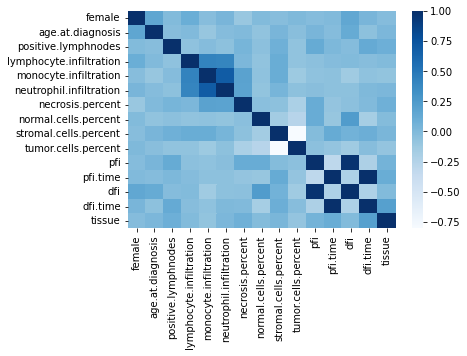

In [ ]:
sns.heatmap(m_df.corr(), cmap="Blues")

In [ ]:
samples = ['female', 'age.at.diagnosis']
y = p_df.pfi
p_df = p_df.dropna(subset=['pfi'])
X = p_df[samples]
print(X.head)
print(y.head)

<bound method NDFrame.head of      female  age.at.diagnosis
0      True                41
1     False                71
2     False                75
3     False                56
4      True                63
..      ...               ...
207    True                55
208   False                62
209   False                57
210   False                49
211    True                68

[212 rows x 2 columns]>
<bound method NDFrame.head of 0      0
1      1
2      1
3      0
4      1
      ..
207    0
208    0
209    0
210    0
211    0
Name: pfi, Length: 212, dtype: int64>


In [ ]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [ ]:
from sklearn.svm import LinearSVC

M2 = LinearSVC()

In [ ]:
M2.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
M2_y_pred = M2.predict(X_test)

In [ ]:
print("R^2: {0:.2}".format(r2_score(y_test, M1_y_pred)))
print("MSE: {0:.3}".format(mean_squared_error(y_test, M1_y_pred)))
print("MAE: {0:.3}".format(mean_absolute_error(y_test, M1_y_pred)))

R^2: -1.4
MSE: 0.581
MAE: 0.581


In [ ]:
# plot_graph(M2_y_pred)

# M3: DNAm predicted protein data.
Measured from both primary tumours and adjacent solid normal tissue samples from TCGA HNSC participants. Prediction on the `tumour.or.normal` cancer-related outcome.

In [ ]:
m2_df = pd.read_csv("/content/sample_data/m/clinical.txt", sep="\t")
m2_df

,participant,female,histology,age.at.diagnosis,ethnicity,race,positive.lymphnodes,stage,tnm.m.category,tnm.n.category,...,normal.cells.percent,stromal.cells.percent,tumor.cells.percent,pfi,pfi.time,dfi,dfi.time,tissue,participant.tissue,tumor.or.normal
0,4074,False,head & neck squamous cell carcinoma,69.0,not hispanic or latino,white,5.0,stage iva,m0,n2,...,0.0,10.0,87.0,1,396.0,NaN,NaN,1,4074-01,tumor
1,4075,False,head & neck squamous cell carcinoma,49.0,not hispanic or latino,black or african american,0.0,stage iii,m0,n0,...,0.0,15.0,70.0,1,236.0,NaN,NaN,1,4075-01,tumor
2,4076,False,head & neck squamous cell carcinoma,39.0,not hispanic or latino,white,NaN,NaN,NaN,NaN,...,0.0,3.0,95.0,1,286.0,NaN,NaN,1,4076-01,tumor
3,4077,True,head & neck squamous cell carcinoma,45.0,not hispanic or latino,white,NaN,stage iva,m0,n0,...,0.0,10.0,85.0,1,1134.0,NaN,NaN,1,4077-01,tumor
4,4078,False,head & neck squamous cell carcinoma,83.0,not hispanic or latino,white,4.0,NaN,NaN,NaN,...,0.0,15.0,80.0,1,276.0,NaN,NaN,1,4078-01,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,A92M,False,head & neck squamous cell carcinoma,52.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0.0,0.0,100.0,1,417.0,NaN,NaN,1,A92M-01,tumor
574,A92N,False,head & neck squamous cell carcinoma,79.0,not hispanic or latino,black or african american,6.0,stage iva,NaN,n2,...,0.0,10.0,90.0,1,46.0,NaN,NaN,1,A92N-01,tumor
575,AA3J,False,head & neck squamous cell carcinoma basaloid type,69.0,not hispanic or latino,black or african american,NaN,stage i,m0,n0,...,0.0,20.0,80.0,0,466.0,0.0,466.0,1,AA3J-01,tumor
576,AA3K,False,head & neck squamous cell carcinoma,60.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0.0,25.0,75.0,0,253.0,NaN,NaN,1,AA3K-01,tumor


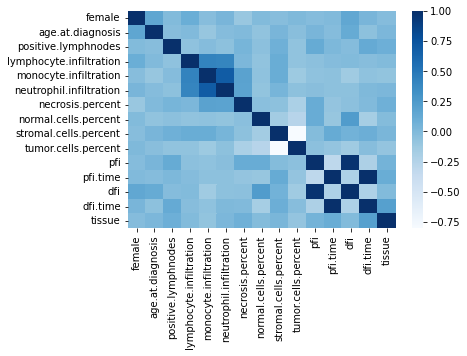

In [ ]:
sns.heatmap(m2_df.corr(), cmap="Blues")

In [ ]:
samples = ['female', 'age.at.diagnosis']
m2_df = m2_df.dropna(subset=['tumor.or.normal', 'female', 'age.at.diagnosis'])
m2_df

,participant,female,histology,age.at.diagnosis,ethnicity,race,positive.lymphnodes,stage,tnm.m.category,tnm.n.category,...,normal.cells.percent,stromal.cells.percent,tumor.cells.percent,pfi,pfi.time,dfi,dfi.time,tissue,participant.tissue,tumor.or.normal
0,4074,False,head & neck squamous cell carcinoma,69.0,not hispanic or latino,white,5.0,stage iva,m0,n2,...,0.0,10.0,87.0,1,396.0,NaN,NaN,1,4074-01,tumor
1,4075,False,head & neck squamous cell carcinoma,49.0,not hispanic or latino,black or african american,0.0,stage iii,m0,n0,...,0.0,15.0,70.0,1,236.0,NaN,NaN,1,4075-01,tumor
2,4076,False,head & neck squamous cell carcinoma,39.0,not hispanic or latino,white,NaN,NaN,NaN,NaN,...,0.0,3.0,95.0,1,286.0,NaN,NaN,1,4076-01,tumor
3,4077,True,head & neck squamous cell carcinoma,45.0,not hispanic or latino,white,NaN,stage iva,m0,n0,...,0.0,10.0,85.0,1,1134.0,NaN,NaN,1,4077-01,tumor
4,4078,False,head & neck squamous cell carcinoma,83.0,not hispanic or latino,white,4.0,NaN,NaN,NaN,...,0.0,15.0,80.0,1,276.0,NaN,NaN,1,4078-01,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,A92M,False,head & neck squamous cell carcinoma,52.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0.0,0.0,100.0,1,417.0,NaN,NaN,1,A92M-01,tumor
574,A92N,False,head & neck squamous cell carcinoma,79.0,not hispanic or latino,black or african american,6.0,stage iva,NaN,n2,...,0.0,10.0,90.0,1,46.0,NaN,NaN,1,A92N-01,tumor
575,AA3J,False,head & neck squamous cell carcinoma basaloid type,69.0,not hispanic or latino,black or african american,NaN,stage i,m0,n0,...,0.0,20.0,80.0,0,466.0,0.0,466.0,1,AA3J-01,tumor
576,AA3K,False,head & neck squamous cell carcinoma,60.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0.0,25.0,75.0,0,253.0,NaN,NaN,1,AA3K-01,tumor


In [ ]:
samples = ['female', 'age.at.diagnosis']
m2_df['tumor.or.normal'].replace(['tumor', 'normal'],
                        [0, 1], inplace=True)
y = m2_df['tumor.or.normal']
print(m2_df)

# for i in range(len(m2_df)):
#   if y.iloc[i] == 'tumor':
#     y.iloc[i] = 1
#   elif y.iloc[i] == 'normal':
#     y.iloc[i] = 0
#   else:
#     print(i)

X = m2_df[samples]
y = m2_df['tumor.or.normal']
print(X.head)
print(y)

    participant  female                                          histology  \
0          4074   False                head & neck squamous cell carcinoma   
1          4075   False                head & neck squamous cell carcinoma   
2          4076   False                head & neck squamous cell carcinoma   
3          4077    True                head & neck squamous cell carcinoma   
4          4078   False                head & neck squamous cell carcinoma   
..          ...     ...                                                ...   
573        A92M   False                head & neck squamous cell carcinoma   
574        A92N   False                head & neck squamous cell carcinoma   
575        AA3J   False  head & neck squamous cell carcinoma basaloid type   
576        AA3K   False                head & neck squamous cell carcinoma   
577        AA8J   False                head & neck squamous cell carcinoma   

     age.at.diagnosis               ethnicity                  

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [ ]:
from sklearn.svm import LinearSVC

M3 = LinearSVC()

In [ ]:
M3.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
M3_y_pred = M3.predict(X_test)

In [ ]:
print("R^2: {0:.2}".format(r2_score(y_test, M3_y_pred)))
print("MSE: {0:.3}".format(mean_squared_error(y_test, M3_y_pred)))
print("MAE: {0:.3}".format(mean_absolute_error(y_test, M3_y_pred)))

R^2: -0.084
MSE: 0.0776
MAE: 0.0776


In [ ]:
# plot_graph(M3_y_pred)